In [1]:
import pandas as pd
import ast
import numpy as np
import os

## Entity normalization tests

### Load SNOMED terminology
Note: 
- SNOMED CT is the most comprehensive, multilingual clinical healthcare terminology in the world. See https://www.snomed.org/five-step-briefing
- SNOMED CT is a terminology that can cross-map to other international terminologies, classifications and code systems. Maps are associations between particular concepts or terms in one system and concepts or terms in another system that have the same (or similar) meaning. See https://www.snomed.org/maps
- Downloaded Current International Edition (RF2 files) from: https://www.nlm.nih.gov/healthit/snomedct/international.html
- we use the snapshot release: A snapshot release is a release type in which the release files contain only the most recent version of every component and reference set member released, as at the release date. See https://confluence.ihtsdotools.org/display/DOCRELFMT/3.2+Release+Types

In [2]:
import networkx as nx
from tqdm import tqdm
from src.Snomed import Snomed
# code from https://github.com/cambridgeltl/sapbert/tree/main

#### V1: using a graph

In [3]:
release_id = '20240401'
SNOMED_PATH = './data/snomed/SnomedCT_InternationalRF2_PRODUCTION_20240401T120000Z' # you need to download your own SNOMED distribution
snomed = Snomed(SNOMED_PATH, release_id=release_id)
snomed.load_snomed()

In [4]:
snomed_sf_id_pairs = []

for snomed_id in tqdm(snomed.graph.nodes):
    
    node_descs = snomed.index_definition[snomed_id]
    for d in node_descs:
        snomed_sf_id_pairs.append((d, snomed_id))

print(len(snomed_sf_id_pairs))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366908/366908 [00:00<00:00, 2307685.16it/s]

971409


In [5]:
snomed_sf_id_pairs[:10]


[('Neoplasm of anterior aspect of epiglottis', '126813005'),
 ('Neoplasm of anterior aspect of epiglottis (disorder)', '126813005'),
 ('Neoplasm of junctional region of epiglottis', '126814004'),
 ('Neoplasm of junctional region of epiglottis (disorder)', '126814004'),
 ('Neoplasm of lateral wall of oropharynx', '126815003'),
 ('Neoplasm of lateral wall of oropharynx (disorder)', '126815003'),
 ('Neoplasm of posterior wall of oropharynx', '126816002'),
 ('Neoplasm of posterior wall of oropharynx (disorder)', '126816002'),
 ('Tumour of posterior wall of oropharynx', '126816002'),
 ('Tumor of posterior wall of oropharynx', '126816002')]

In [6]:
snomed_sf_id_pairs_100k = snomed_sf_id_pairs[:100000] # for simplicity

all_names = [p[0] for p in snomed_sf_id_pairs]
all_ids = [p[1] for p in snomed_sf_id_pairs]

In [7]:
all_names[:10]

['Neoplasm of anterior aspect of epiglottis',
 'Neoplasm of anterior aspect of epiglottis (disorder)',
 'Neoplasm of junctional region of epiglottis',
 'Neoplasm of junctional region of epiglottis (disorder)',
 'Neoplasm of lateral wall of oropharynx',
 'Neoplasm of lateral wall of oropharynx (disorder)',
 'Neoplasm of posterior wall of oropharynx',
 'Neoplasm of posterior wall of oropharynx (disorder)',
 'Tumour of posterior wall of oropharynx',
 'Tumor of posterior wall of oropharynx']

In [8]:
all_ids[:10]

['126813005',
 '126813005',
 '126814004',
 '126814004',
 '126815003',
 '126815003',
 '126816002',
 '126816002',
 '126816002',
 '126816002']

#### V2: using df

In [5]:
#https://github.com/drivendataorg/snomed-ct-entity-linking/blob/main/1st%20Place/src/process_data.py
from pathlib import Path
def load_snomed_ct(data_path: Path, release_id: str):
    """
    Create a SNOMED CT concept DataFrame.

    Derived from: https://github.com/CogStack/MedCAT/blob/master/medcat/utils/preprocess_snomed.py

    Returns:
        pandas.DataFrame: SNOMED CT concept DataFrame.
    """

    def _read_file_and_subset_to_active(filename):
        with open(filename, encoding="utf-8") as f:
            entities = [[n.strip() for n in line.split("\t")] for line in f]
            df = pd.DataFrame(entities[1:], columns=entities[0])
        return df[df.active == "1"]

    active_terms = _read_file_and_subset_to_active(
         f"{data_path}/sct2_Concept_Snapshot_INT_{release_id}.txt"
    )
    active_descs = _read_file_and_subset_to_active(
        f"{data_path}/sct2_Description_Snapshot-en_INT_{release_id}.txt"
    )

    df = pd.merge(active_terms, active_descs, left_on=["id"], right_on=["conceptId"], how="inner")[
        ["id_x", "term", "typeId"]
    ].rename(columns={"id_x": "concept_id", "term": "concept_name", "typeId": "name_type"})

    print("Loaded SNOMED size: ", df.shape)

    # active description or active synonym
    df["name_type"] = df["name_type"].replace(
        ["900000000000003001", "900000000000013009"], ["Canonical", "Synonym"]
    )
    active_snomed_df = df[df.name_type.isin(["Canonical", "Synonym"])]
    print("Active SNOMED size: ", active_snomed_df.shape)

    active_snomed_df["hierarchy"] = active_snomed_df["concept_name"].str.extract(
        r"\((\w+\s?.?\s?\w+.?\w+.?\w+.?)\)$"
    )

    return active_snomed_df

In [6]:
snomed_path = 'data/snomed/SnomedCT_InternationalRF2_PRODUCTION_20240401T120000Z/Snapshot/Terminology'
snomed_df = load_snomed_ct(snomed_path, release_id)

Loaded SNOMED size:  (971409, 3)
Active SNOMED size:  (971409, 3)


In [7]:
snomed_df.shape

(971409, 4)

In [8]:
snomed_df.head()

,concept_id,concept_name,name_type,hierarchy
0,101009,Quilonia ethiopica,Synonym,NaN
1,101009,Quilonia ethiopica (organism),Canonical,organism
2,102002,Hemoglobin Okaloosa,Synonym,NaN
3,102002,"Hb 48(CD7), Leu-arg",Synonym,NaN
4,102002,Haemoglobin Okaloosa,Synonym,NaN


In [9]:
len(snomed_df[snomed_df['hierarchy']=="disorder"]), len(snomed_df[snomed_df['hierarchy']=="substance"])

(86389, 27484)

In [10]:
# Identify canonical concept_names and their hierarchy
canonical_hierarchy = snomed_df[snomed_df['name_type'] == 'Canonical'][['concept_id', 'hierarchy']]

# Merge to propagate the hierarchy to synonyms
snomed_df = snomed_df.merge(canonical_hierarchy, on='concept_id', suffixes=('', '_canonical'), how='left')
# Update the hierarchy column for synonyms
snomed_df['hierarchy'] = snomed_df['hierarchy'].fillna(snomed_df['hierarchy_canonical'])

# Drop the auxiliary column used for propagation
snomed_df.drop(columns=['hierarchy_canonical'], inplace=True)


In [11]:
snomed_df[snomed_df['concept_id']=="24700007"]

,concept_id,concept_name,name_type,hierarchy
56507,24700007,Multiple sclerosis,Synonym,disorder
56508,24700007,Multiple sclerosis (disorder),Canonical,disorder
56509,24700007,Disseminated sclerosis,Synonym,disorder
56510,24700007,MS - Multiple sclerosis,Synonym,disorder
56511,24700007,DS - Disseminated sclerosis,Synonym,disorder


In [12]:
snomed_df[snomed_df['concept_id']=="426373005"]

,concept_id,concept_name,name_type,hierarchy
643061,426373005,Relapsing remitting multiple sclerosis (disorder),Canonical,disorder
643062,426373005,Relapsing remitting multiple sclerosis,Synonym,disorder
643063,426373005,Multiple sclerosis (MS) relapsing remitting,Synonym,disorder


In [13]:
concept_type_subset_reference = [
    "procedure",  # top level category
    "body structure",  # top level category
    "finding",  # top level category
    "disorder",  # child of finding
    "morphologic abnormality",  # child of body structure
    "regime/therapy",  # child of procedure
    "cell structure",  # child of body structure
]

In [14]:
concept_type_subset = [
    "disorder",  
    "substance"
]

filtered_df = snomed_df[snomed_df.hierarchy.isin(concept_type_subset)] # Filter the SNOMED data to the selected Concept Types
filtered_df.head()

,concept_id,concept_name,name_type,hierarchy
2,102002,Hemoglobin Okaloosa,Synonym,substance
3,102002,"Hb 48(CD7), Leu-arg",Synonym,substance
4,102002,Haemoglobin Okaloosa,Synonym,substance
5,102002,Hemoglobin Okaloosa (substance),Canonical,substance
17,109006,Anxiety disorder of childhood OR adolescence,Synonym,disorder


In [15]:
# Filter to get only canonical forms
canonical_df = filtered_df[filtered_df['name_type'] == 'Canonical']

# Create the dictionary
canonical_dict = pd.Series(canonical_df['concept_name'].values, index=canonical_df['concept_id']).to_dict()

dict_canoncial_json_file_path = './data/snomed/mapping_dictionaries/disorder_substance_canonical_dict.json'
with open(dict_canoncial_json_file_path, 'w') as json_file:
    json.dump(canonical_dict, json_file)


In [16]:
filtered_df.shape

(316752, 4)

In [17]:
all_names = filtered_df['concept_name'].values.tolist()
all_ids = filtered_df['concept_id'].values.tolist()
len(all_names), len(all_ids)

(316752, 316752)

In [18]:
snomed_sf_id_pairs = []

for snomed_name, snomed_id in zip(all_names, all_ids):
    snomed_sf_id_pairs.append((snomed_name, snomed_id))

In [19]:
snomed_sf_id_pairs[:5]

[('Hemoglobin Okaloosa', '102002'),
 ('Hb 48(CD7), Leu-arg', '102002'),
 ('Haemoglobin Okaloosa', '102002'),
 ('Hemoglobin Okaloosa (substance)', '102002'),
 ('Anxiety disorder of childhood OR adolescence', '109006')]

In [20]:
all_names[:5]

['Hemoglobin Okaloosa',
 'Hb 48(CD7), Leu-arg',
 'Haemoglobin Okaloosa',
 'Hemoglobin Okaloosa (substance)',
 'Anxiety disorder of childhood OR adolescence']

In [21]:
all_ids[:5]

['102002', '102002', '102002', '102002', '109006']

### Load SAPBert

In [22]:
from transformers import AutoTokenizer, AutoModel 
import torch
from scipy.spatial.distance import cdist


In [23]:
tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext")  
model = AutoModel.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext")

#### encode snomed labels -> once!

In [25]:
bs = 128  # Batch size for processing
large_batch_size = 100000  # Size of the large batch to process each time
batch_name_prefix = "disorder_substance_emb" # all_reps_emb_full

In [75]:

def process_and_save_batch(name_subset, batch_idx):
    all_reps = []
    for i in tqdm(range(0, len(name_subset), bs)):
        toks = tokenizer.batch_encode_plus(name_subset[i:i+bs], 
                                           padding="max_length", 
                                           max_length=25, 
                                           truncation=True,
                                           return_tensors="pt")
        # If using a GPU, uncomment the following lines
        # toks_cuda = {k: v.cuda() for k, v in toks.items()}
        # output = model(**toks_cuda)
        
        # For CPU usage (or adjust as needed for your GPU setup)
        output = model(**toks)
        cls_rep = output[0][:,0,:]
        all_reps.append(cls_rep.cpu().detach().numpy())
    
    all_reps_emb_full = np.concatenate(all_reps, axis=0)
    # Save to a binary file using numpy
    np.save(f'./data/embeddings/snomed_normalization/{batch_name_prefix}_batch_{batch_idx}.npy', all_reps_emb_full)

# Process all names in chunks of 100000
for batch_start in range(0, len(all_names), large_batch_size):
    batch_end = min(batch_start + large_batch_size, len(all_names))
    name_subset = all_names[batch_start:batch_end]
    process_and_save_batch(name_subset, batch_start // large_batch_size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [01:50<00:00,  1.19it/s]


#### load snomed embeddings

In [26]:
# Define the directory where your files are stored
directory_path = './data/embeddings/snomed_normalization'

# List all files in the directory that match the pattern
files = [f for f in os.listdir(directory_path) if f.startswith(f'{batch_name_prefix}_batch_') and f.endswith('.npy')]

# Sort files to maintain the order, especially important if the batch index is used in processing
files.sort()

# Initialize an empty list to hold the data from each file
all_data = []

# Load each file and append the data to the list
for file in files:
    file_path = os.path.join(directory_path, file)
    data = np.load(file_path)
    all_data.append(data)

# Concatenate all the arrays from the list into one
all_reps_emb_full = np.concatenate(all_data, axis=0)

In [27]:
all_reps_emb_full.shape

(316752, 768)

In [28]:
# Read the dictionary back from the JSON file
with open(dict_canoncial_json_file_path, 'r') as json_file:
    canonical_mapping_dict = json.load(json_file)
canonical_mapping_dict['426373005']

'Relapsing remitting multiple sclerosis (disorder)'

# Query SNOMED

In [231]:
import numpy as np
import torch
from transformers import PreTrainedTokenizer, PreTrainedModel
from typing import Any, Tuple, Dict, List, Union
from scipy.spatial.distance import cdist

def map_to_snomed(query: str, 
                  tokenizer: PreTrainedTokenizer, 
                  model: PreTrainedModel, 
                  all_reps_emb_full: np.ndarray, 
                  snomed_sf_id_pairs: np.ndarray, 
                  canonical_mapping_dict: Dict[str, str],
                  n_entities: int = 3) -> Tuple[int, str, str, List[Tuple[str, int]], float]:
    
    """
    Map a query to the closest SNOMED concept using a pre-trained model and return its canonical form.

    Parameters:
    - query (str): The input query string to be mapped.
    - tokenizer (PreTrainedTokenizer): The tokenizer used for encoding the query.
    - model (PreTrainedModel): The pre-trained model used to generate embeddings for the query.
    - all_reps_emb_full (np.ndarray): The array of embeddings for all SNOMED concepts.
    - snomed_sf_id_pairs (np.ndarray): The array of SNOMED concept ID and label pairs.
    - canonical_mapping_dict (Dict[str, str]): A dictionary mapping SNOMED IDs to their canonical forms.
    - n_entities (int): The number of nearest entities to retrieve.

    Returns:
    - Tuple[int, str, str, List[Tuple[str, int]], float]: The predicted SNOMED concept ID, label, its canonical form,
      a list of the nearest entities, and the minimum distance.
    """
    # Move embeddings to GPU if available
    if torch.cuda.is_available():
        all_reps_emb_full_tensor = torch.tensor(all_reps_emb_full).to('cuda')

    if torch.cuda.is_available():
        model = model.to('cuda')
        
    # Encode the query
    query_toks = tokenizer.batch_encode_plus([query], 
                                             padding="max_length", 
                                             max_length=25, 
                                             truncation=True,
                                             return_tensors="pt")
    if torch.cuda.is_available():
        query_toks = query_toks.to('cuda')  # Move tensors to GPU
        
    # Get the model output
    with torch.no_grad():
        query_output = model(**query_toks)
    
    # Extract the CLS token representation
    query_cls_rep = query_output[0][:, 0, :]

    # Compute distances between query embedding and all SNOMED concept embeddings
    dist = torch.cdist(query_cls_rep, all_reps_emb_full_tensor)
    #dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)

    # Find the nearest neighbor
    nn_index = np.argmin(dist).item()
    min_distance = dist[0, nn_index].item()  # Extract the minimum distance

    # Retrieve the nearest n_entities
    nearest_n_entities = []
    nearest_n_indices = torch.argsort(dist[0])[:n_entities]  # Get indices of the n smallest distances
    for idx in nearest_n_indices:
        nearest_n_entities.append(snomed_sf_id_pairs[idx.item()])
        
    # Get the predicted SNOMED concept ID and label
    predicted_label = snomed_sf_id_pairs[nn_index]
    predicted_id = predicted_label[1]

    # Get the canonical form from the dictionary
    canonical_form = canonical_mapping_dict.get(predicted_id, "Canonical form not found")

    # Return the predicted SNOMED concept ID, label, and canonical form
    return predicted_id, predicted_label[0], canonical_form, nearest_n_entities, round(min_distance, 4)

# Example usage
query = "multiple sclerosis"
predicted_id, predicted_label, canonical_form, nearest_3_entities, nn_distance = map_to_snomed(query, tokenizer, model, all_reps_emb_full, snomed_sf_id_pairs, canonical_mapping_dict)
print("Predicted ID:", predicted_id)
print("Predicted label:", predicted_label)
print("Distance:", nn_distance)
print("Canonical form:", canonical_form)
print("Nearest 3: ", nearest_3_entities)


Predicted ID: 24700007
Predicted label: Multiple sclerosis
Distance: 0.0055
Canonical form: Multiple sclerosis (disorder)
Nearest 3:  [('Multiple sclerosis', '24700007'), ('Multiple sclerosis (disorder)', '24700007'), ('MS - Multiple sclerosis', '24700007')]


# Map NeuroTrialNER test set to SNOMED

In [54]:
df = pd.read_csv("data/annotated_aact/neurotrial_ner/all_predictions_aggregated_all_entity_types.csv")[['nct_id','unique_condition_target', 'unique_drug_target']]

In [88]:
df_condition = df[['nct_id','unique_condition_target']].dropna()
df_drug = df[['nct_id','unique_drug_target']].dropna()

In [89]:
df_condition.shape, df_drug.shape

((144, 2), (50, 2))

In [90]:
df_condition.head()

,nct_id,unique_condition_target
0,NCT04045665,coronary artery bypass graft|isolated coronary...
1,NCT02311036,-cerebrovascular diseases
2,NCT05369793,diabetic neuropathy|type 2 diabetic
3,NCT04483310,narcolepsy|sleep paralyses|sleep paralysis
4,NCT01418976,"chronic, mild-to-moderate, traumatic brain inj..."


In [134]:
df_condition_flat = df_condition.copy()
df_condition_flat['unique_condition_target'] = df_condition_flat['unique_condition_target'].str.split('|')
df_condition_flat = df_condition_flat.explode('unique_condition_target')
df_condition_flat.head()

,nct_id,unique_condition_target
0,NCT04045665,coronary artery bypass graft
0,NCT04045665,isolated coronary artery bypass graft (cabg) s...
0,NCT04045665,new-onset post-operative atrial fibrillation
0,NCT04045665,post-operative atrial fibrillation
1,NCT02311036,-cerebrovascular diseases


In [135]:
tqdm.pandas(desc="Mapping test NER to SNOMED")

In [232]:
def process_row_annotations(
    row: Union[str, float], 
    tokenizer: Any, 
    model: Any, 
    all_reps_emb_full: Any, 
    snomed_sf_id_pairs: Dict[str, str], 
    canonical_mapping_dict: Dict[str, str]
) -> Tuple[str, str, str, str, str, Dict[str, List[str]], Dict[str, str]]:
    """
    Processes a row of annotations, mapping terms to SNOMED CT concepts and returning the results.

    Parameters:
    - row (Union[str, float]): A string of terms separated by '|', or NaN.
    - tokenizer (Any): The tokenizer used for mapping terms.
    - model (Any): The model used for mapping terms.
    - all_reps_emb_full (Any): The embeddings used for mapping terms.
    - snomed_sf_id_pairs (Dict[str, str]): Dictionary of SNOMED ID and term pairs.
    - canonical_mapping_dict (Dict[str, str]): Dictionary mapping terms to their canonical forms.

    Returns:
    - Tuple[str, str, str, str, str, Dict[str, List[str]], Dict[str, str]]:
        - Concatenated SNOMED terms.
        - Concatenated SNOMED term IDs.
        - Concatenated canonical forms of the SNOMED terms.
        - Concatenated closest 3 entities.
        - Concatenated minimum distances.
        - Dictionary mapping canonical forms to lists of terms.
        - Dictionary mapping terms to their canonical forms.
    """    
    if pd.isna(row) or not isinstance(row, str):
        # Return empty strings and empty dictionaries for all the values
        return "", "", "", {}, {}, "", ""
    
    terms = row.split('|')
    snomed_terms = []
    snomed_terms_canonical = []
    snomed_termids = []
    snomed_norms = []
    closest_3_entites = []
    min_distances = []  # List to store minimum distances

    # Dictionaries to track mappings
    norm_to_terms = {}  # SNOMED norm as key, list of terms as values
    term_to_norm = {}   # Each term from the row and the SNOMED norm to which it was mapped

    for term in terms:
        predicted_id, predicted_label, canonical_form, n_3_entities, nn_distance = map_to_snomed(term, tokenizer, model, all_reps_emb_full, snomed_sf_id_pairs, canonical_mapping_dict)
        snomed_terms.append(predicted_label)
        snomed_terms_canonical.append(canonical_form)
        snomed_termids.append(predicted_id)
        min_distances.append(nn_distance)
        closest_3_entites.append(n_3_entities)

        # Populate dictionaries
        #print(canonical_form)
        if canonical_form in norm_to_terms:
            norm_to_terms[canonical_form].append(term)
        else:
            norm_to_terms[canonical_form] = [term]

        term_to_norm[term] = canonical_form

    # Ensure unique terms in norm_to_terms dictionary
    for key in norm_to_terms:
        norm_to_terms[key] = list(set(norm_to_terms[key]))

    return '|'.join(snomed_terms), '|'.join(snomed_termids), '|'.join(snomed_terms_canonical), '|'.join([str(ents) for ents in closest_3_entites]), '|'.join([str(dist) for dist in min_distances]),  norm_to_terms, term_to_norm

In [233]:
results_normalization = df_condition_flat['unique_condition_target'].progress_apply(
    lambda x: pd.Series(process_row_annotations(x, tokenizer, model, all_reps_emb_full, snomed_sf_id_pairs, canonical_mapping_dict))
)
df_condition_flat[['snomed_term', 'snomed_termid', 'snomed_term_norm', 'snomed_closest_3', 'cdist']] = results_normalization[[0, 1, 2, 3, 4]]

Mapping test NER to SNOMED: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [01:09<00:00,  4.97it/s]


In [214]:
df_condition_flat

,nct_id,unique_condition_target,snomed_term,snomed_termid,snomed_term_norm,cdist,snomed_closest_3
0,NCT04045665,coronary artery bypass graft,Coronary arteriosclerosis of coronary artery b...,429673002,Arteriosclerosis of coronary artery bypass gra...,12.0023,[('Coronary arteriosclerosis of coronary arter...
0,NCT04045665,isolated coronary artery bypass graft (cabg) s...,Significant coronary bypass graft disease,371805005,Significant coronary bypass graft disease (dis...,13.5419,"[('Significant coronary bypass graft disease',..."
0,NCT04045665,new-onset post-operative atrial fibrillation,Persistent atrial fibrillation,440059007,Persistent atrial fibrillation (disorder),10.8733,"[('Persistent atrial fibrillation', '440059007..."
0,NCT04045665,post-operative atrial fibrillation,Postoperative cardiac arrhythmia,1230406008,Cardiac arrhythmia following operative procedu...,11.7939,"[('Postoperative cardiac arrhythmia', '1230406..."
1,NCT02311036,-cerebrovascular diseases,Cerebrovascular disease (disorder),62914000,Cerebrovascular disease (disorder),3.3552,"[('Cerebrovascular disease (disorder)', '62914..."
...,...,...,...,...,...,...,...
152,NCT03661411,acute ischemic stroke,Ischemic stroke,422504002,Ischemic stroke (disorder),7.675,"[('Ischemic stroke', '422504002'), ('Acute cer..."
152,NCT03661411,acute mild ischemic stroke,Nonparalytic stroke,111297002,Nonparalytic stroke (disorder),11.096,"[('Nonparalytic stroke', '111297002'), ('Nonpa..."
152,NCT03661411,acute minor stroke,Nonparalytic stroke,111297002,Nonparalytic stroke (disorder),9.8478,"[('Nonparalytic stroke', '111297002'), ('Nonpa..."
152,NCT03661411,minor stroke,Nonparalytic stroke,111297002,Nonparalytic stroke (disorder),8.8132,"[('Nonparalytic stroke', '111297002'), ('Nonpa..."


In [139]:
hierarchies_df = pd.read_csv("data/snomed/disorder_substance_snomed_node_hierarchies.csv")[['Node', 'Parents', 'Parents_Desc']]
hierarchies_df.rename(columns={"Node":"snomed_termid"}, inplace=True)

In [144]:
# Convert both columns to string
df_condition_flat['snomed_termid'] = df_condition_flat['snomed_termid'].astype(str)
hierarchies_df['snomed_termid'] = hierarchies_df['snomed_termid'].astype(str)

df_condition_flat_with_hierarchy = pd.merge(df_condition_flat, hierarchies_df, on='snomed_termid', how='left')

In [145]:
df_condition_flat_with_hierarchy

,nct_id,unique_condition_target,snomed_term,snomed_termid,snomed_term_norm,cdist,Parents,Parents_Desc
0,NCT04045665,coronary artery bypass graft,Coronary arteriosclerosis of coronary artery b...,429673002,Arteriosclerosis of coronary artery bypass gra...,12.0023,"[362975008, 72092001, 64572001, 19660004, 1189...","['Degenerative disorder', 'Arteriosclerotic va..."
1,NCT04045665,isolated coronary artery bypass graft (cabg) s...,Significant coronary bypass graft disease,371805005,Significant coronary bypass graft disease (dis...,13.5419,"[359557001, 362965005, 362975008, 56265001, 70...","['Arterial disease', 'Disorder of body system'..."
2,NCT04045665,new-onset post-operative atrial fibrillation,Persistent atrial fibrillation,440059007,Persistent atrial fibrillation (disorder),10.8733,"[64572001, 49436004, 118946009, 6456007, 56265...","['Disease', 'Atrial fibrillation', 'Disorder o..."
3,NCT04045665,post-operative atrial fibrillation,Postoperative cardiac arrhythmia,1230406008,Cardiac arrhythmia following operative procedu...,11.7939,"[64572001, 233816003, 738668004, 56265001, 494...","['Disease', 'Postoperative cardiac complicatio..."
4,NCT02311036,-cerebrovascular diseases,Cerebrovascular disease (disorder),62914000,Cerebrovascular disease (disorder),3.3552,"[64572001, 362965005, 49601007]","['Disease', 'Disorder of body system', 'Cardio..."
...,...,...,...,...,...,...,...,...
340,NCT03661411,acute ischemic stroke,Ischemic stroke,422504002,Ischemic stroke (disorder),7.675,"[127296001, 87536007, 362965005, 82271004, 128...","['Intracranial injury', 'Central nervous syste..."
341,NCT03661411,acute mild ischemic stroke,Nonparalytic stroke,111297002,Nonparalytic stroke (disorder),11.096,"[127296001, 128239009, 64572001, 118940003, 28...","['Intracranial injury', 'Injury of nervous sys..."
342,NCT03661411,acute minor stroke,Nonparalytic stroke,111297002,Nonparalytic stroke (disorder),9.8478,"[127296001, 128239009, 64572001, 118940003, 28...","['Intracranial injury', 'Injury of nervous sys..."
343,NCT03661411,minor stroke,Nonparalytic stroke,111297002,Nonparalytic stroke (disorder),8.8132,"[127296001, 128239009, 64572001, 118940003, 28...","['Intracranial injury', 'Injury of nervous sys..."


In [146]:
nan_parents = df_condition_flat_with_hierarchy[df_condition_flat_with_hierarchy['Parents'].isna()]
nan_parents

,nct_id,unique_condition_target,snomed_term,snomed_termid,snomed_term_norm,cdist,Parents,Parents_Desc


In [149]:
def convert_to_int_list(lst):
    if isinstance(lst, list):
        return [int(item) for item in lst]
    else:
        return [int(item) for item in ast.literal_eval(lst)]
        
df_condition_flat_with_hierarchy['Parents'] = df_condition_flat_with_hierarchy['Parents'].apply(convert_to_int_list)


In [154]:
df_condition_flat_with_hierarchy[df_condition_flat_with_hierarchy['snomed_termid']=='118940003']

,nct_id,unique_condition_target,snomed_term,snomed_termid,snomed_term_norm,cdist,Parents,Parents_Desc,Filtered_Parents,Top_Concept
180,NCT05706831,neurological diseases,Neurological disorder,118940003,Disorder of nervous system (disorder),2.8499,"[64572001, 362965005]","['Disease', 'Disorder of body system']",[],[]


In [206]:
# Convert Node column to set for faster lookup
# exclude the very generic 
# 118940003: Disorder of nervous system (disorder) 
# 49601007: Disorder of cardiovascular system (disorder)
# 62914000: Cerebrovascular disease (disorder)
# 127294003: Traumatic or nontraumatic brain injury (disorder)
# 128139000: Inflammatory disorder (disorder)
# 52448006: Dementia (disorder)
node_set = set(map(int, df_condition_flat_with_hierarchy['snomed_termid'])) - {118940003, 49601007, 62914000, 127294003, 128139000, 52448006}  

# Filter Descendants based on whether they appear in the Node column
df_condition_flat_with_hierarchy['Filtered_Parents'] = df_condition_flat_with_hierarchy['Parents'].apply(lambda x: [item for item in x if item in node_set])

# The elements which have no parent, i.e. they are at the highest level in their hierarchy tree
main_parent_nodes = df_condition_flat_with_hierarchy[df_condition_flat_with_hierarchy['Filtered_Parents'].apply(lambda x: len(x) == 0)]['snomed_termid']
main_parent_nodes_set = set(map(int,main_parent_nodes)) 

df_condition_flat_with_hierarchy['Top_Concept'] = df_condition_flat_with_hierarchy['Filtered_Parents'].apply(
    lambda x: [node for node in x if node in main_parent_nodes_set] if len(x) > 1 else x # if there is already only one parent node, keep it
)
canonical_form = canonical_mapping_dict.get(predicted_id, "Canonical form not found")

df_condition_flat_with_hierarchy['Top_Concept_Canonical'] = df_condition_flat_with_hierarchy['Top_Concept'].apply(
    lambda x: [canonical_mapping_dict.get(str(node), "Canonical form not found") for node in x] #if len(x) > 1 else x #canonical_mapping_dict.get(x[0], "Canonical form not found") # if there is already only one parent node, keep it
)
# Create a new column with the first element from Top_Concept_Canonical
df_condition_flat_with_hierarchy['Top_Concept_Canonical_First'] = df_condition_flat_with_hierarchy['Top_Concept_Canonical'].apply(
    lambda x: x[0] if x else None
)
# Fill empty values in Top_Concept_Canonical_First with values from snomed_term_norm
df_condition_flat_with_hierarchy['Top_Concept_Canonical_First'] = df_condition_flat_with_hierarchy['Top_Concept_Canonical_First'].fillna(
    df_condition_flat_with_hierarchy['snomed_term_norm']
)
df_condition_flat_with_hierarchy

,nct_id,unique_condition_target,snomed_term,snomed_termid,snomed_term_norm,cdist,Parents,Parents_Desc,Filtered_Parents,Top_Concept,Top_Concept_Canonical,Top_Concept_Canonical_First
0,NCT04045665,coronary artery bypass graft,Coronary arteriosclerosis of coronary artery b...,429673002,Arteriosclerosis of coronary artery bypass gra...,12.0023,"[362975008, 72092001, 64572001, 19660004, 1189...","['Degenerative disorder', 'Arteriosclerotic va...",[],[],[],Arteriosclerosis of coronary artery bypass gra...
1,NCT04045665,isolated coronary artery bypass graft (cabg) s...,Significant coronary bypass graft disease,371805005,Significant coronary bypass graft disease (dis...,13.5419,"[359557001, 362965005, 362975008, 56265001, 70...","['Arterial disease', 'Disorder of body system'...",[385486001],[385486001],[Postoperative complication (disorder)],Postoperative complication (disorder)
2,NCT04045665,new-onset post-operative atrial fibrillation,Persistent atrial fibrillation,440059007,Persistent atrial fibrillation (disorder),10.8733,"[64572001, 49436004, 118946009, 6456007, 56265...","['Disease', 'Atrial fibrillation', 'Disorder o...",[49436004],[49436004],[Atrial fibrillation (disorder)],Atrial fibrillation (disorder)
3,NCT04045665,post-operative atrial fibrillation,Postoperative cardiac arrhythmia,1230406008,Cardiac arrhythmia following operative procedu...,11.7939,"[64572001, 233816003, 738668004, 56265001, 494...","['Disease', 'Postoperative cardiac complicatio...",[385486001],[385486001],[Postoperative complication (disorder)],Postoperative complication (disorder)
4,NCT02311036,-cerebrovascular diseases,Cerebrovascular disease (disorder),62914000,Cerebrovascular disease (disorder),3.3552,"[64572001, 362965005, 49601007]","['Disease', 'Disorder of body system', 'Cardio...",[],[],[],Cerebrovascular disease (disorder)
...,...,...,...,...,...,...,...,...,...,...,...,...
340,NCT03661411,acute ischemic stroke,Ischemic stroke,422504002,Ischemic stroke (disorder),7.675,"[127296001, 87536007, 362965005, 82271004, 128...","['Intracranial injury', 'Central nervous syste...",[230690007],[230690007],[Cerebrovascular accident (disorder)],Cerebrovascular accident (disorder)
341,NCT03661411,acute mild ischemic stroke,Nonparalytic stroke,111297002,Nonparalytic stroke (disorder),11.096,"[127296001, 128239009, 64572001, 118940003, 28...","['Intracranial injury', 'Injury of nervous sys...",[230690007],[230690007],[Cerebrovascular accident (disorder)],Cerebrovascular accident (disorder)
342,NCT03661411,acute minor stroke,Nonparalytic stroke,111297002,Nonparalytic stroke (disorder),9.8478,"[127296001, 128239009, 64572001, 118940003, 28...","['Intracranial injury', 'Injury of nervous sys...",[230690007],[230690007],[Cerebrovascular accident (disorder)],Cerebrovascular accident (disorder)
343,NCT03661411,minor stroke,Nonparalytic stroke,111297002,Nonparalytic stroke (disorder),8.8132,"[127296001, 128239009, 64572001, 118940003, 28...","['Intracranial injury', 'Injury of nervous sys...",[230690007],[230690007],[Cerebrovascular accident (disorder)],Cerebrovascular accident (disorder)


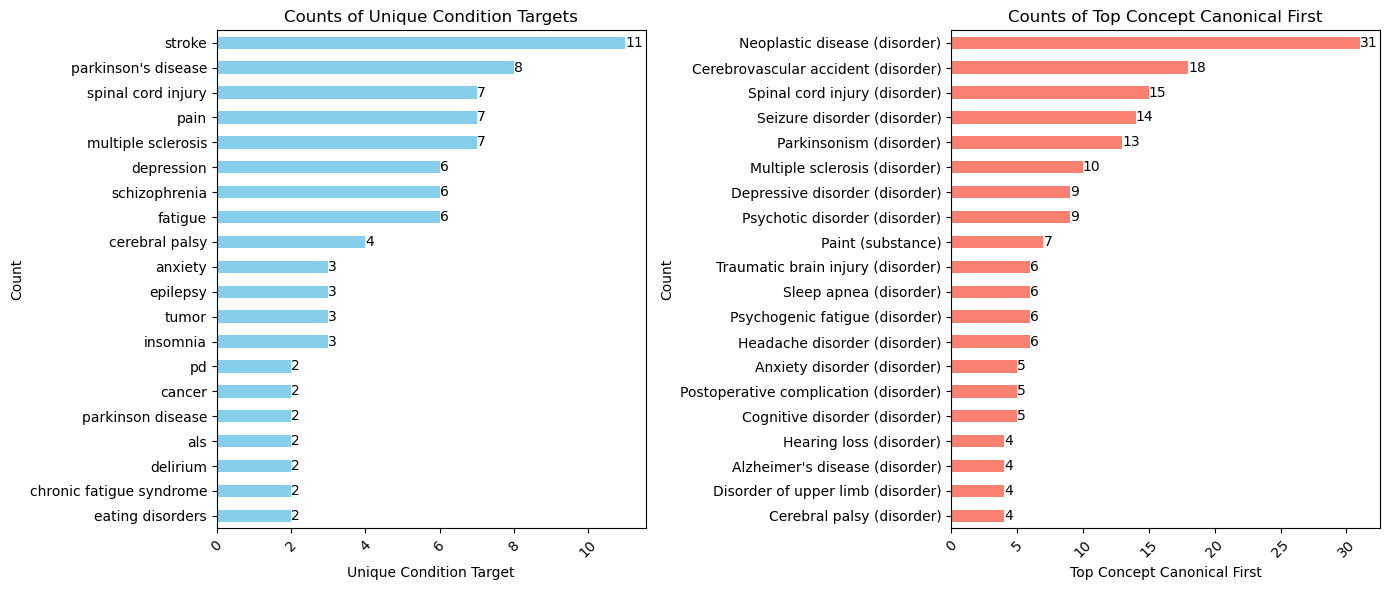

In [207]:
import matplotlib.pyplot as plt

# Aggregate counts for unique_condition_target and sort them in descending order
unique_condition_counts = df_condition_flat_with_hierarchy['unique_condition_target'].value_counts().nlargest(20)

# Aggregate counts for Top_Concept_Canonical_First and sort them in descending order
top_concept_counts = df_condition_flat_with_hierarchy['Top_Concept_Canonical_First'].value_counts().nlargest(20)


# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot unique_condition_target counts
unique_condition_counts[::-1].plot(kind='barh', ax=axs[0], color='skyblue')
axs[0].set_title('Counts of Unique Condition Targets')
axs[0].set_xlabel('Unique Condition Target')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=45)
# Add count labels to each bar
for i in range(len(unique_condition_counts)):
    axs[0].text(unique_condition_counts.iloc[::-1].values[i], i, str(unique_condition_counts.iloc[::-1].values[i]), va='center')


# Plot Top_Concept_Canonical_First counts
top_concept_counts[::-1].plot(kind='barh', ax=axs[1], color='salmon')
axs[1].set_title('Counts of Top Concept Canonical First')
axs[1].set_xlabel('Top Concept Canonical First')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)

# Add count labels to each bar
for i in range(len(top_concept_counts)):
    axs[1].text(top_concept_counts.iloc[::-1].values[i], i, str(top_concept_counts.iloc[::-1].values[i]), va='center')


plt.tight_layout()
plt.show()

In [189]:
df_condition_flat_with_hierarchy.to_csv("data/annotated_aact/neurotrial_ner/neurotrial_ner_conditions_test_mapped.csv")

# Generate SNOMED hieararchies

In [47]:
import pandas as pd
import networkx as nx

# Load data from a CSV file
file_path = 'data/snomed/SnomedCT_InternationalRF2_PRODUCTION_20240401T120000Z/Snapshot/Terminology/sct2_Relationship_Snapshot_INT_20240401.txt'
data = pd.read_csv(file_path, delimiter='\t')

# Filter data for active=1 and typeId=116680003 (IS_A relationships)
filtered_data = data[(data['active'] == 1) & (data['typeId'] == 116680003)]

# Create a directed graph
G = nx.DiGraph()

# Add edges from sourceId to destinationId
all_ids_set = set(map(int, all_ids))

for idx, row in filtered_data.iterrows():
    source_id = int(row['sourceId'])
    destination_id = int(row['destinationId'])
    # Filter for disorder and substance nodes using the set for faster lookup
    if (source_id in all_ids_set) and (destination_id in all_ids_set):
        G.add_edge(source_id, destination_id)

# Generate a dictionary of all nodes with their reachable nodes
#all_hierarchies = {node: list(nx.descendants(G, node)) for node in G.nodes}

# Generate a dictionary of all nodes with their reachable and originating nodes
node_list = []
for node in G.nodes:
    descendants = list(nx.descendants(G, node))  # Nodes reachable from 'node'
    ancestors = list(nx.ancestors(G, node))  # Nodes that can reach 'node'
    node_list.append([node, descendants, ancestors])

# Create DataFrame from the list
hierarchies_df = pd.DataFrame(node_list, columns=['Node', 'Parents', 'Children'])


In [48]:
hierarchies_df

,Node,Parents,Children
0,10007009,"[110359009, 128124001, 66091009, 64572001, 118...",[]
1,82354003,"[66091009, 64572001, 414025005, 276654001, 529...","[718848000, 205824006, 1208746001, 51626007, 7..."
2,1002007,"[299987008, 312415009, 767307008, 115668003, 4...",[]
3,130090009,"[299987008, 312415009, 767307008, 115668003, 4...","[46187009, 71168005, 7061005, 32725008, 790180..."
4,10031004,"[91720002, 260769002, 50473004, 32457005, 1156...",[]
...,...,...,...
113868,1331983003,"[767307008, 415664003, 49616005, 106181007, 11...",[]
113869,1290571000000108,"[24851008, 312415009, 27380003, 441900009, 312...",[]
113870,1290841000000104,"[238147009, 64572001, 414029004, 128139000, 36...",[]
113871,1290821000000106,"[128127008, 312132001, 312428002, 128351009, 6...",[]


In [49]:
def get_description(snomed_obj, id):
    try:
        return snomed_obj[id]['desc']  # Modify this based on how descriptions are stored in your Snomed object
    except KeyError:
        return 'Unknown'

# Apply mapping to Node, Descendants, and Ancestors columns
hierarchies_df['Node_Desc'] = hierarchies_df['Node'].apply(lambda x: get_description(snomed, x))
hierarchies_df['Parents_Desc'] = hierarchies_df['Parents'].apply(lambda ids: [get_description(snomed, id) for id in ids])
hierarchies_df['Children_Desc'] = hierarchies_df['Children'].apply(lambda ids: [get_description(snomed, id) for id in ids])


In [50]:
hierarchies_df.to_csv("data/snomed/disorder_substance_snomed_node_hierarchies.csv")
hierarchies_df.head()

,Node,Parents,Children,Node_Desc,Parents_Desc,Children_Desc
0,10007009,"[110359009, 128124001, 66091009, 64572001, 118...",[],Coffin-Siris syndrome,"[Intellectual disability, Congenital anomaly o...",[]
1,82354003,"[66091009, 64572001, 414025005, 276654001, 529...","[718848000, 205824006, 1208746001, 51626007, 7...",Multiple system malformation syndrome,"[Congenital disease, Disease, Disorder of fetu...","[Fried syndrome (disorder), Noonan's syndrome,..."
2,1002007,"[299987008, 312415009, 767307008, 115668003, 4...",[],Mannotetraose 2-alpha-N-acetylglucosaminyltran...,"[Amide and/or amide derivative (substance), Ch...",[]
3,130090009,"[299987008, 312415009, 767307008, 115668003, 4...","[46187009, 71168005, 7061005, 32725008, 790180...",Hexosyltransferase,"[Amide and/or amide derivative (substance), Ch...","[Abequosyltransferase, Alpha,alpha-trehalose p..."
4,10031004,"[91720002, 260769002, 50473004, 32457005, 1156...",[],Vulvar secretions,"[Body substance, Material (substance), Female ...",[]


## testing

In [51]:
filtered_disease_nodes = hierarchies_df[hierarchies_df['Node'].isin([64572001])]
filtered_disease_nodes
# Create an expanded DataFrame for children and their descriptions
children = filtered_disease_nodes.apply(lambda x: pd.Series(zip(x['Children'], x['Children_Desc'])), axis=1).stack().reset_index(level=1, drop=True)
children_df = pd.DataFrame(children.tolist(), columns=['Child', 'Child_Desc'], index=children.index)

# Merge expanded DataFrame back with the original data
filtered_disease_nodes = filtered_disease_nodes.drop(columns=['Children', 'Children_Desc'])  # Drop original list columns
filtered_disease_nodes = filtered_disease_nodes.join(children_df)  # Join expanded child data
filtered_disease_nodes

,Node,Parents,Node_Desc,Parents_Desc,Child,Child_Desc
10808,64572001,[],Disease,[],63701002,"Panic disorder with agoraphobia, mild agorapho..."
10808,64572001,[],Disease,[],17111000119107,Ischemic ulcer of skin
10808,64572001,[],Disease,[],10666711000119108,Pressure injury of right lower leg stage IV (d...
10808,64572001,[],Disease,[],1208746001,"Intellectual disability, muscle weakness, shor..."
10808,64572001,[],Disease,[],94634005,Secondary malignant neoplasm of thyroid gland
...,...,...,...,...,...,...
10808,64572001,[],Disease,[],1082071000119102,Primary squamous cell carcinoma of left ear (d...
10808,64572001,[],Disease,[],724566007,Neurological disorder due to excess intake of ...
10808,64572001,[],Disease,[],460587000,Anomalous origin of single coronary artery fro...
10808,64572001,[],Disease,[],1835003,Necrosis of pancreas


In [52]:
filtered_rows = hierarchies_df[hierarchies_df['Node'].isin([58214004, 79204003, 191526005, 1204417003, 83746006, 35489007, 394924000, 24700007, 426373005])]

In [53]:
# Convert Node column to set for faster lookup
node_set = set(filtered_rows['Node'])

# Filter Descendants based on whether they appear in the Node column
filtered_rows['Filtered_Parents'] = filtered_rows['Parents'].apply(lambda x: [item for item in x if item in node_set])

main_parent_nodes = filtered_rows[filtered_rows['Filtered_Parents'].apply(lambda x: len(x) == 0)]['Node']
main_parent_nodes_set = set(main_parent_nodes)

filtered_rows['Top_Concept'] = filtered_rows['Filtered_Parents'].apply(
    lambda x: [node for node in x if node in main_parent_nodes_set] if len(x) > 1 else x
)
filtered_rows

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_28218/3340653008.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['Filtered_Parents'] = filtered_rows['Parents'].apply(lambda x: [item for item in x if item in node_set])
/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_28218/3340653008.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['Top_Concept'] = filtered_rows['Filtered_Parents'].apply(


,Node,Parents,Children,Node_Desc,Parents_Desc,Children_Desc,Filtered_Parents,Top_Concept
1072,58214004,"[64572001, 69322001, 74732009]","[111483008, 191547009, 30336007, 85861002, 396...",Schizophrenia,"[Disease, Psychotic disorder, Mental disorder]","[Catatonic schizophrenia in remission, Acute e...",[],[]
1076,35489007,"[64572001, 74732009, 46206005]","[191616006, 832007, 10211000132109, 82218004, ...",Depressive disorder,"[Disease, Mental disorder, Mood disorder]","[Recurrent depression, Moderate major depressi...",[],[]
5667,24700007,"[362975008, 64572001, 363171009, 118940003, 23...","[192927008, 733028000, 816984002, 230372003, 1...",Multiple sclerosis,"[Degenerative disorder, Disease, Inflammation ...","[Multiple sclerosis of the spinal cord, Multip...",[],[]
23177,83746006,"[64572001, 27624003, 74732009, 128293007, 6932...","[79204003, 191548004, 30336007, 191531007, 352...",Chronic schizophrenia,"[Disease, Chronic disease, Mental disorder, Ch...",[Chronic undifferentiated schizophrenia with a...,[58214004],[58214004]
36977,79204003,"[64572001, 111484002, 27624003, 74732009, 1282...",[],Chronic undifferentiated schizophrenia with ac...,"[Disease, Undifferentiated schizophrenia, Chro...",[],"[58214004, 83746006]",[58214004]
42524,191526005,"[64572001, 69322001, 58214004, 74732009]",[],Schizophrenic disorders,"[Disease, Psychotic disorder, Schizophrenia, M...",[],[58214004],[58214004]
63448,426373005,"[362975008, 64572001, 363171009, 118940003, 24...",[],Relapsing remitting multiple sclerosis (disorder),"[Degenerative disorder, Disease, Inflammation ...",[],[24700007],[24700007]
103624,1204417003,"[64572001, 118940003, 74732009, 362965005, 693...",[],Early onset schizophrenia,"[Disease, Neurological disorder, Mental disord...",[],[58214004],[58214004]


In [134]:
main_parent_nodes

12586      58214004
12598      35489007
24190      24700007
172482    394924000
Name: Node, dtype: int64

In [129]:
filtered_rows.to_csv("data/snomed/snomed_node_hierarchies_examples.csv")

# Testing of Functionalities

In [83]:
query = "multiple sclerosis"
query_toks = tokenizer.batch_encode_plus([query], 
                                       padding="max_length", 
                                       max_length=25, 
                                       truncation=True,
                                       return_tensors="pt")
query_output = model(**query_toks)
query_cls_rep = query_output[0][:,0,:]
dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)
nn_index = np.argmin(dist)
print ("predicted label:", snomed_sf_id_pairs[nn_index])


predicted label: ('Multiple sclerosis', '24700007')


In [84]:
nn_indices = np.argsort(dist[0])[:3]  # Get indices of three smallest distances

print("Top 3 predicted labels:")
for idx in nn_indices:
    print(snomed_sf_id_pairs[idx])

Top 3 predicted labels:
('Multiple sclerosis', '24700007')
('Multiple sclerosis (disorder)', '24700007')
('MS - Multiple sclerosis', '24700007')


In [17]:
snomed['24700007']

{'desc': 'Multiple sclerosis'}

In [126]:
query = "multiple sclerosis, relapsing-remitting"
query_toks = tokenizer.batch_encode_plus([query], 
                                       padding="max_length", 
                                       max_length=25, 
                                       truncation=True,
                                       return_tensors="pt")
query_output = model(**query_toks)
query_cls_rep = query_output[0][:,0,:]
dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)
nn_index = np.argmin(dist)
print ("predicted label:", snomed_sf_id_pairs[nn_index])

predicted label: ('Relapsing remitting multiple sclerosis', '426373005')


In [127]:
nn_indices = np.argsort(dist[0])[:3]  # Get indices of three smallest distances

print("Top 3 predicted labels:")
for idx in nn_indices:
    print(snomed_sf_id_pairs[idx])

Top 3 predicted labels:
('Relapsing remitting multiple sclerosis', '426373005')
('Relapsing remitting multiple sclerosis (disorder)', '426373005')
('Multiple sclerosis (MS) relapsing remitting', '426373005')


#### anorexia variations

#### encode query

In [87]:
query = "anorexic"
query_toks = tokenizer.batch_encode_plus([query], 
                                       padding="max_length", 
                                       max_length=25, 
                                       truncation=True,
                                       return_tensors="pt")
query_output = model(**query_toks)
query_cls_rep = query_output[0][:,0,:]

#### find query nearest neighbour

In [88]:
dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)
nn_index = np.argmin(dist)
print ("predicted label:", snomed_sf_id_pairs[nn_index])

predicted label: ('Anorexia nervosa (disorder)', '56882008')


In [102]:
snomed['79890006'], snomed.predecessors('79890006')

({'desc': 'Loss of appetite'}, ['289162002'])

In [103]:
snomed['405788002'], snomed.predecessors('405788002')

({'desc': 'Psychogenic loss of appetite'}, ['79890006', '72366004'])

In [104]:
snomed['72366004'], snomed.predecessors('72366004')

({'desc': 'Eating disorder'}, ['231520001'])

In [95]:
snomed['231520001'], snomed.predecessors('231520001')

({'desc': 'Behavioural syndrome associated with physiological disturbance and physical factors'},
 ['74732009'])

In [96]:
snomed['74732009'], snomed.predecessors('74732009')

({'desc': 'Mental disorder'}, ['64572001'])

In [97]:
snomed['64572001'], snomed.predecessors('64572001')

({'desc': 'Disease'}, ['404684003'])

In [160]:
snomed['289162002'], snomed.predecessors('289162002'), snomed['289161009'], snomed.predecessors('289161009')

({'desc': 'Finding of quantity of appetite'},
 ['289161009'],
 {'desc': 'Finding of appetite'},
 ['116336009', '118228005'])

In [161]:
snomed['118228005'], snomed.predecessors('118228005'), snomed['404684003'], snomed.predecessors('404684003'), snomed['138875005'], snomed.predecessors('138875005')

({'desc': 'Functional finding'},
 ['404684003'],
 {'desc': 'Clinical finding (finding)'},
 ['138875005'],
 {'desc': 'SNOMED CT Concept'},
 [])

In [90]:
snomed['116336009'], snomed.predecessors('116336009')

({'desc': 'Eating feeding and drinking observations'}, ['404684003'])

In [93]:
snomed['404684003'], snomed.predecessors('404684003')

({'desc': 'Clinical finding (finding)'}, ['138875005'])

#### schizophrenia variations
- schizophrenia: predicted label: ('Schizophrenia', '58214004')
- schizophrenic: predicted label: ('Schizophrenic disorders', '191526005'), predecessors: 58214004
- first-episode schizophrenia: predicted label: ('Early onset schizophrenia', '1204417003'), predecessors: ['58214004', '118940003']
- chronic schizophrenia: predicted label: ('Chronic schizophrenia', '83746006')

In [89]:
query = "chronic schizophrenia"
query_toks = tokenizer.batch_encode_plus([query], 
                                       padding="max_length", 
                                       max_length=25, 
                                       truncation=True,
                                       return_tensors="pt")
query_output = model(**query_toks)
query_cls_rep = query_output[0][:,0,:]
dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)
nn_index = np.argmin(dist)
print ("predicted label:", snomed_sf_id_pairs[nn_index])

predicted label: ('Chronic schizophrenia', '83746006')


In [125]:
snomed['83746006'], snomed.predecessors('83746006'), snomed.successors('83746006')

({'desc': 'Chronic schizophrenia'},
 ['128293007', '58214004'],
 ['12939007', '29599000', '31658008', '68995007', '71103003', '191531007'])

In [117]:
snomed['1204417003'], snomed.predecessors('1204417003'), snomed.successors('1204417003')

({'desc': 'Early onset schizophrenia'}, ['58214004', '118940003'], [])

In [108]:
snomed['58214004'], snomed.predecessors('58214004'), snomed.successors('58214004')

({'desc': 'Schizophrenia'},
 ['69322001'],
 ['191527001',
  '191542003',
  '111484002',
  '268617001',
  '26025008',
  '26472000',
  '35252006',
  '64905009',
  '83746006',
  '191526005',
  '191577003',
  '247804008',
  '416340002',
  '4926007',
  '1204417003'])

In [128]:
snomed['128293007'], snomed.predecessors('128293007'), snomed['27624003'], snomed.predecessors('27624003'), snomed['74732009'], snomed.predecessors('74732009')

({'desc': 'Chronic mental illness'},
 ['27624003', '74732009'],
 {'desc': 'Chronic disease'},
 ['64572001'],
 {'desc': 'Mental disorder'},
 ['64572001'])

In [122]:
 snomed['118940003'], snomed.predecessors('118940003'), snomed['362965005'], snomed.predecessors('362965005'),  snomed['64572001'], snomed.predecessors('64572001')

({'desc': 'Neurological disorder'},
 ['362965005'],
 {'desc': 'Disorder of body system'},
 ['64572001'],
 {'desc': 'Disease'},
 ['404684003'])

In [123]:
 snomed['69322001'], snomed.predecessors('69322001'), snomed['74732009'], snomed.predecessors('74732009'), snomed['64572001'], snomed.predecessors('64572001')

({'desc': 'Psychotic disorder'},
 ['74732009'],
 {'desc': 'Mental disorder'},
 ['64572001'],
 {'desc': 'Disease'},
 ['404684003'])

In [34]:
snomed['404684003'], snomed.predecessors('404684003')

({'desc': 'Clinical finding (finding)'}, ['138875005'])

In [35]:
snomed['138875005'], snomed.predecessors('138875005')

({'desc': 'SNOMED CT Concept'}, [])

#### bipolar variations
- 'bipolar',
- 'bipolar 1 disorder',
- 'bipolar disorder',
- 'bipolar disorder i',
- 'bipolar hypomania',
- 'bipolar i',
- 'bipolar i disorder',
- 'bipolar i or ii disorder',
- 'bipolar ii disorder',
- 'bipolar mania',
- 'bipolar or schizoaffective disorder',
- 'bipolar spectrum disorder',
- 'bipolar spectrum disorders',
- 'bipolar spectrum or',

In [131]:
def map_to_snomed(query):
    query_toks = tokenizer.batch_encode_plus([query], 
                                       padding="max_length", 
                                       max_length=25, 
                                       truncation=True,
                                       return_tensors="pt")
    query_output = model(**query_toks)
    query_cls_rep = query_output[0][:,0,:]
    dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)
    nn_index = np.argmin(dist)
    print ("predicted label:", snomed_sf_id_pairs[nn_index])

In [163]:
map_to_snomed('rgbm'), snomed.predecessors('260994008')

predicted label: ('RGM', '116494006')


(None, ['277425009'])

In [142]:
map_to_snomed('bipolar'), snomed.predecessors('260994008')

predicted label: ('Bipolar', '260994008')


(None, ['277425009'])

In [147]:
snomed['260994008'], snomed.predecessors('260994008'), snomed['277425009'], snomed.predecessors('277425009'),  snomed['255277001'], snomed.predecessors('255277001'),  snomed['272099008'], snomed.predecessors('272099008')

({'desc': 'Bipolar'},
 ['277425009'],
 {'desc': 'Polar formations'},
 ['255277001'],
 {'desc': 'Formations'},
 ['272099008'],
 {'desc': 'Descriptor (qualifier value)'},
 ['362981000'])

In [141]:
map_to_snomed('bipolar spectrum disorders')

predicted label: ('Bipolar disorder', '13746004')


In [133]:
map_to_snomed('bipolar 1 disorder')

predicted label: ('Bipolar 1 disorder', '371596008')


In [134]:
map_to_snomed('bipolar i disorder')

predicted label: ('Bipolar I disorder', '371596008')


In [135]:
map_to_snomed('bipolar i')

predicted label: ('Bipolar I disorder', '371596008')


In [136]:
map_to_snomed('bipolar ii disorder')

predicted label: ('Bipolar II disorder', '83225003')


In [137]:
map_to_snomed('bipolar hypomania')

predicted label: ('Hypomanic mood', '281257007')


In [138]:
map_to_snomed('bipolar mania')

predicted label: ('Manic bipolar I disorder (disorder)', '68569003')


cognitive impairment

In [154]:
map_to_snomed('cognitive impairment'), map_to_snomed('cognitive dysfunction'), map_to_snomed('cognitive deficit')

predicted label: ('Cognitive impairment', '386806002')
predicted label: ('Cognitive dysfunction', '386806002')
predicted label: ('Cognitive deficit', '386806002')


(None, None, None)

In [155]:
snomed['386806002']

{'desc': 'Impaired cognition (finding)'}

#### Tests for Drugs

In [ ]:
map_to_snomed('pimavanserin')


In [159]:
snomed['721997002'], snomed.predecessors('721997002'), snomed['372521009'], snomed.predecessors('372521009'), snomed['412053006'], snomed.predecessors('412053006')

({'desc': 'Pimavanserin (substance)'},
 ['372521009', '412053006', '372482001'],
 {'desc': 'Piperidine derivative (substance)'},
 ['123682001'],
 {'desc': 'Urea and/or urea derivative'},
 ['41175001'])

# Mapping of Full Linked Data to Top Concept Node

In [696]:
snomed_node_hierarchies = pd.read_csv("data/snomed/snomed_node_hierarchies.csv")[['Node', 'Parents', 'Parents_Desc', 'Children', 'Children_Desc']]
snomed_node_hierarchies.head()

,Node,Parents,Parents_Desc,Children,Children_Desc
0,10000006,"[302292003, 404684003, 9972008, 298705000, 222...","['Finding of trunk structure', 'Clinical findi...",[],[]
1,29857009,"[302292003, 404684003, 298705000, 22253000, 10...","['Finding of trunk structure', 'Clinical findi...","[279019008, 83264000, 279038004, 1264062004, 3...","['Central crushing chest pain', 'Epidemic pleu..."
2,9972008,"[404684003, 22253000, 102957003, 106147001, 13...","['Clinical finding (finding)', 'Pain', 'Neurol...","[10000006, 427653003, 427365005, 426469008, 12...","['Radiating chest pain', 'Pain radiating to ri..."
3,134035007,"[421371008, 312779009, 69536005, 47173002, 281...","['Structure of lateral half of head', 'Bone st...",[],[]
4,84371003,"[421371008, 312779009, 69536005, 47173002, 281...","['Structure of lateral half of head', 'Bone st...",[134035007],['Entire stylomastoid foramen']


In [697]:
model = 'linkbert'
if model  == 'linkbert':
    ner_output_col = 'canonical_BioLinkBERT-base_conditions'
else:
    ner_output_col = 'canonical_aact_conditions'
df_cond = pd.read_csv("data/annotated_aact/sapbert_normalized_annotations_linkbert_19607.csv")[['nct_id', ner_output_col, f'{model}_snomed_termid',	f'{model}_snomed_term_norm']]
df_cond.head()

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm
0,NCT00000117,multiple sclerosis|optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis
1,NCT00000146,multiple sclerosis|optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis
2,NCT00000147,multiple sclerosis|optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis
3,NCT00000151,blindness|diabetes mellitus|diabetic retinopat...,65956007|73211009|4855003|312906006|313165001,Legal blindness|Diabetes mellitus|Diabetic ret...
4,NCT00000170,amblyopia|anisometropia|moderate amblyopia|str...,387742006|3289004|397542006|22066006,Amblyopia (disorder)|Anisometropia|Moderate vi...


In [698]:
columns_to_explode = [ner_output_col, f'{model}_snomed_termid',	f'{model}_snomed_term_norm']

for col in columns_to_explode:
    # Convert column to string, but handle None correctly
    df_cond[col] = df_cond[col].apply(lambda x: x.split('|') if pd.notnull(x) else [])
    

In [699]:
df_cond

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm
0,NCT00000117,"[multiple sclerosis, optic neuritis]","[24700007, 66760008]","[Multiple sclerosis, Optic neuritis]"
1,NCT00000146,"[multiple sclerosis, optic neuritis]","[24700007, 66760008]","[Multiple sclerosis, Optic neuritis]"
2,NCT00000147,"[multiple sclerosis, optic neuritis]","[24700007, 66760008]","[Multiple sclerosis, Optic neuritis]"
3,NCT00000151,"[blindness, diabetes mellitus, diabetic retino...","[65956007, 73211009, 4855003, 312906006, 31316...","[Legal blindness, Diabetes mellitus, Diabetic ..."
4,NCT00000170,"[amblyopia, anisometropia, moderate amblyopia,...","[387742006, 3289004, 397542006, 22066006]","[Amblyopia (disorder), Anisometropia, Moderate..."
...,...,...,...,...
19602,NCT06293911,"[down syndrome, gingival inflammation, periodo...","[41040004, 66383009, 41565005]","[Complete trisomy 21 syndrome, Gingivitis, Per..."
19603,NCT06294236,"[gleam, severe autoimmune diseases, severe rel...","[895221001, 4301008, 722290008]","[Genus Gleimia, Autoimmune state, Autoimmune l..."
19604,NCT06294821,"[carpal tunnel release, carpal tunnel syndrome...","[47534009, 57406009, 45781009]","[Decompression of median nerve, Carpal tunnel ..."
19605,NCT06296082,"[post-stroke, post-stroke spasticity, spastici...","[11764003, 108691000119102, 221360009, 230690007]","[Postconcussion state, Spasticity as sequela o..."


In [700]:
filtered_df = df_cond[df_cond['canonical_BioLinkBERT-base_conditions'].apply(len) != df_cond['linkbert_snomed_termid'].apply(len)]
filtered_df

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm
13,NCT00000179,"[ad, agitation]",[24199005],[Agitation]
25,NCT00000210,"[aids, concurrent intravenous heroin and cocai...","[1255012001, 91388009]","[Combined substance dependence, continuous, Ps..."
26,NCT00000211,"[aids, concurrent intravenous heroin and cocai...","[1255012001, 91388009]","[Combined substance dependence, continuous, Ps..."
101,NCT00000321,"[aids, methamphetamine, methamphetamine depend...","[387499002, 426873000]","[Methamphetamine, Methamphetamine dependence (..."
125,NCT00000368,"[agoraphobia, panic disorder, pd]","[70691001, 371631005]","[Agoraphobia, Panic disorder (disorder)]"
...,...,...,...,...
19571,NCT06276504,"[hiv, hiv infection, immunocompromised, jcv, l...","[86406008, 370388006, 22255007, 22255007]","[Human immunodeficiency virus infection, Patie..."
19574,NCT06279858,"[fragile x, fragile x syndrome, fxs]","[205720009, 613003]","[Fragile X chromosome, Fragile X syndrome]"
19581,NCT06282640,"[carpal tunnel syndrome, cts, pain]","[57406009, 22253000]","[Carpal tunnel syndrome, Pain]"
19584,NCT06285006,"[mne, monosymptomatic nocturnal enuresis, nmne...","[450845009, 8009008]","[Primary nocturnal enuresis, Bed wetting]"


In [701]:
df_cond_filtered = df_cond[df_cond['canonical_BioLinkBERT-base_conditions'].apply(len) == df_cond['linkbert_snomed_termid'].apply(len)]
df_cond_filtered.shape


(17300, 4)

In [702]:
df_non_standard_types = df_cond[df_cond.applymap(lambda x: not isinstance(x, (int, float, str, tuple, list))).any(axis=1)]
df_non_standard_types

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_98515/4039978171.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_non_standard_types = df_cond[df_cond.applymap(lambda x: not isinstance(x, (int, float, str, tuple, list))).any(axis=1)]


,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm


In [703]:
df_exploded_cond = df_cond_filtered.explode(columns_to_explode).reset_index(drop=True)
df_exploded_cond.head()

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm
0,NCT00000117,multiple sclerosis,24700007,Multiple sclerosis
1,NCT00000117,optic neuritis,66760008,Optic neuritis
2,NCT00000146,multiple sclerosis,24700007,Multiple sclerosis
3,NCT00000146,optic neuritis,66760008,Optic neuritis
4,NCT00000147,multiple sclerosis,24700007,Multiple sclerosis


In [704]:
df_exploded_cond = df_exploded_cond.dropna()


In [705]:
len(set(df_exploded_cond['nct_id']))

15993

In [706]:
# If your IDs are stored as strings or if there's a type mismatch, explicitly convert them
df_exploded_cond[f'{model}_snomed_termid'] = df_exploded_cond[f'{model}_snomed_termid'].astype(int)
snomed_node_hierarchies['Node'] = snomed_node_hierarchies['Node'].astype(int)

condition_hierarchies =  pd.merge(df_exploded_cond, snomed_node_hierarchies, left_on=f'{model}_snomed_termid', right_on='Node', how='left')

# Assuming 'Node' is a single integer value column and 'Parents' is a list of integers
condition_hierarchies['Node'] = condition_hierarchies['Node'].astype(int)

# For 'Parents', if it's a list of numbers stored as strings, you'll need to convert each element in the list individually
condition_hierarchies['Parents'] = condition_hierarchies['Parents'].apply(
    lambda x: [int(i) for i in ast.literal_eval(x)] if x and x != '[]' else []
)
condition_hierarchies.head()

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm,Node,Parents,Parents_Desc,Children,Children_Desc
0,NCT00000117,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul..."
1,NCT00000117,optic neuritis,66760008,Optic neuritis,66760008,"[73013002, 77157004, 362965005, 21018002, 5476...","['Cranial nerve disorder', 'Disorder of optic ...","[230507009, 1169360001, 866133000, 73221001, 5...","['RBN - Retrobulbar neuritis', 'Chronic relaps..."
2,NCT00000146,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul..."
3,NCT00000146,optic neuritis,66760008,Optic neuritis,66760008,"[73013002, 77157004, 362965005, 21018002, 5476...","['Cranial nerve disorder', 'Disorder of optic ...","[230507009, 1169360001, 866133000, 73221001, 5...","['RBN - Retrobulbar neuritis', 'Chronic relaps..."
4,NCT00000147,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul..."


In [719]:
# Convert Node column to set for faster lookup Encephalomyeloneuropathy	23853001
node_set = set(condition_hierarchies['Node']) - {410942007, 844005, 129104009, 700364009, 5294002, 57697001, 107669003, 49755003, 105590001, 71388002, 65971000052100,128283000,301766008,70835005,399317006, 60342002, 1821000146108, 91388009, 441527004, 275471001, 26416006, 442406005, 128293007, 46206005, 27624003, 2704003, 85828009, 66214007, 1254812006, 75934005, 52448006, 52522001, 64572001, 404684003, 74732009, 69322001, 138875005, 118940003, 128139000, 23853001, 363171009, 6118003, 39367000, 42658009, 106030000, 106030000, 106028002, 928000, 129565002, 14817008, 417163006, 49601007, 81308009, 386806002} 
# exclude very generic nodes here? like ['Disease', 'Clinical finding (finding)', 'Mental disorder', 'Psychotic disorder', 'SNOMED CT Concept', 'Neurological disorder', 'Inflammatory disroder', 'Encephalomyeloneuropathy' ] = [64572001, 404684003, 74732009, 69322001, 138875005]

# Filter Descendants based on whether they appear in the Node column
condition_hierarchies['Filtered_Parents'] = condition_hierarchies['Parents'].apply(lambda x: [item for item in x if item in node_set])

main_parent_nodes = condition_hierarchies[condition_hierarchies['Filtered_Parents'].apply(lambda x: len(x) == 0)]['Node']
main_parent_nodes_set = set(main_parent_nodes) - {64572001} # EXCLUDE THE GENERIC 'Disease' Parent

condition_hierarchies['Top_Concept'] = condition_hierarchies['Filtered_Parents'].apply(
    lambda x: [node for node in x if node in main_parent_nodes_set] if len(x) > 1 else x # AND x should not be the generic Disease
)

condition_hierarchies['Top_Concept_Desc'] = condition_hierarchies['Top_Concept'].apply(lambda ids: [get_description(snomed, id) for id in ids])

condition_hierarchies.head()

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm,Node,Parents,Parents_Desc,Children,Children_Desc,Filtered_Parents,Top_Concept,Top_Concept_Desc
0,NCT00000117,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul...",[],[],[]
1,NCT00000117,optic neuritis,66760008,Optic neuritis,66760008,"[73013002, 77157004, 362965005, 21018002, 5476...","['Cranial nerve disorder', 'Disorder of optic ...","[230507009, 1169360001, 866133000, 73221001, 5...","['RBN - Retrobulbar neuritis', 'Chronic relaps...","[73013002, 77157004, 21018002, 386033004]",[386033004],[Neuropathy (disorder)]
2,NCT00000146,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul...",[],[],[]
3,NCT00000146,optic neuritis,66760008,Optic neuritis,66760008,"[73013002, 77157004, 362965005, 21018002, 5476...","['Cranial nerve disorder', 'Disorder of optic ...","[230507009, 1169360001, 866133000, 73221001, 5...","['RBN - Retrobulbar neuritis', 'Chronic relaps...","[73013002, 77157004, 21018002, 386033004]",[386033004],[Neuropathy (disorder)]
4,NCT00000147,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul...",[],[],[]


In [710]:
condition_hierarchies[condition_hierarchies['linkbert_snomed_term_norm'].str.contains('Stroke', na=False)]


,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm,Node,Parents,Parents_Desc,Children,Children_Desc,Filtered_Parents,Top_Concept
590,NCT00004727,antiplatelet stroke,135875009,Stroke prevention,135875009,"[169443000, 362961001, 71388002, 138875005]","['Preventive procedure', 'Procedure by intent'...",[],[],[],[]
2472,NCT00129805,secondary prevention of cerebral infarction,135875009,Stroke prevention,135875009,"[169443000, 362961001, 71388002, 138875005]","['Preventive procedure', 'Procedure by intent'...",[],[],[],[]
11149,NCT00781326,cerebrovascular risk,135877001,Stroke risk,135877001,"[254291000, 138875005, 273249006]","['Staging and scales', 'SNOMED CT Concept', 'A...","[438367009, 713678009]","['Congestive heart failure, hypertension, age ...",[],[]
22586,NCT02239120,embolic stroke of undetermined source,230713003,Stroke of uncertain pathology,230713003,"[127296001, 362965005, 406122000, 82271004, 10...","['Intracranial injury', 'Disorder of body syst...","[230714009, 230715005]",['Anterior circulation stroke of uncertain pat...,"[82271004, 128239009, 127294003, 128126004, 62...","[82271004, 128239009, 62914000]"
23104,NCT02313909,embolic stroke of undetermined source,230713003,Stroke of uncertain pathology,230713003,"[127296001, 362965005, 406122000, 82271004, 10...","['Intracranial injury', 'Disorder of body syst...","[230714009, 230715005]",['Anterior circulation stroke of uncertain pat...,"[82271004, 128239009, 127294003, 128126004, 62...","[82271004, 128239009, 62914000]"
39765,NCT05559398,acute ischemic stroke therapy,135875009,Stroke prevention,135875009,"[169443000, 362961001, 71388002, 138875005]","['Preventive procedure', 'Procedure by intent'...",[],[],[],[]
41550,NCT05995600,aps-stroke,736709006,Postural Assessment Scale for Stroke Patients ...,736709006,"[254291000, 138875005, 273249006]","['Staging and scales', 'SNOMED CT Concept', 'A...",[],[],[],[]


106028002: Musculoskeletal finding	
106030000: Muscle observation	
267078001: Involuntary movement	
386806002: Impaired cognition (finding)	

In [712]:
condition_hierarchies[condition_hierarchies['Node']==62914000] # 22253000: pain, 48694002: anxiety

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm,Node,Parents,Parents_Desc,Children,Children_Desc,Filtered_Parents,Top_Concept
3135,NCT00165737,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
3981,NCT00208611,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
5219,NCT00261573,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
5908,NCT00313716,cerebral vascular dysfunction,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
7018,NCT00402480,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
12841,NCT00962988,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
14604,NCT01146132,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
16643,NCT01419275,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
19297,NCT01762475,cerebrovascular dysfunction,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
26487,NCT02838589,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]


In [713]:
condition_hierarchies_multiple_top = condition_hierarchies[condition_hierarchies['Top_Concept'].apply(lambda x: len(x) > 1)]

In [714]:
condition_hierarchies_multiple_top

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm,Node,Parents,Parents_Desc,Children,Children_Desc,Filtered_Parents,Top_Concept
7,NCT00000151,diabetes mellitus,73211009,Diabetes mellitus,73211009,"[64572001, 404684003, 20957000, 126877002, 362...","['Disease', 'Clinical finding (finding)', 'Dis...","[46635009, 870528001, 721088003, 609579009, 11...","['Diabetes mellitus type I', 'Newly diagnosed ...","[126877002, 362969004]","[126877002, 362969004]"
80,NCT00000246,rapid benzodiazepine detoxification,770571009,Benzodiazepine therapy,770571009,"[128927009, 71388002, 416608005, 1263452006, 2...","['Procedure by method', 'Procedure', 'Drug the...",[],[],"[416608005, 72641008]","[416608005, 72641008]"
94,NCT00000266,schizophrenic cocaine abusers,735750005,Psychotic disorder with schizophreniform sympt...,735750005,"[11387009, 362965005, 406122000, 762325009, 69...",['Psychoactive substance-induced organic menta...,[],[],"[1187220002, 724729003, 191447007, 191483003]","[1187220002, 191447007]"
99,NCT00000268,attention deficit disorder,35253001,"Attention deficit hyperactivity disorder, pred...",35253001,"[64572001, 404684003, 118228005, 229712006, 24...","['Disease', 'Clinical finding (finding)', 'Fun...",[698689005],"['Attention deficit hyperactivity disorder, pr...","[406506008, 54319003]","[406506008, 54319003]"
268,NCT00000389,social phobia,25501002,Social phobia,25501002,"[386808001, 64572001, 198288003, 247832004, 40...","['Phobia (finding)', 'Disease', 'Anxiety state...","[62351001, 191724005, 191725006, 191726007]","['Generalized social phobia', 'Social phobia, ...","[386808001, 198288003, 247832004, 197480006, 4...","[247832004, 48694002]"
...,...,...,...,...,...,...,...,...,...,...,...
42802,NCT06290713,"muscular dystrophy, duchenne",76670001,Duchenne muscular dystrophy,76670001,"[240048000, 928000, 66091009, 73573004, 362965...",['X-linked muscular dystrophy with abnormal dy...,[],[],"[240048000, 240046001, 363058009, 79191007, 73...","[363058009, 79191007]"
42806,NCT06293300,"brain injuries, traumatic",127295002,Traumatic brain injury,127295002,"[127296001, 362965005, 406122000, 82271004, 12...","['Intracranial injury', 'Disorder of body syst...","[230763008, 722624003, 1003584006, 870549000, ...","['Traumatic cerebral oedema', 'Focal traumatic...","[82271004, 128239009, 127294003, 128126004, 41...","[82271004, 128239009, 417746004]"
42810,NCT06293911,gingival inflammation,66383009,Gingivitis,66383009,"[362965005, 406122000, 423066003, 118938008, 8...","['Disorder of body system', 'Head finding (fin...","[707792000, 709147009, 22208002, 22240003, 234...",['Necrotizing ulcerative gingivitis (disorder)...,"[50410009, 128999004, 2556008]","[50410009, 128999004]"
42811,NCT06293911,periodontal inflammation,41565005,Periodontitis,41565005,"[362965005, 406122000, 423066003, 118938008, 8...","['Disorder of body system', 'Head finding (fin...","[1184704003, 1149440003, 716117004, 715285004,...",['Periodontitis exacerbated by hypophosphatasi...,"[50410009, 128999004, 2556008]","[50410009, 128999004]"


In [715]:
len(set(condition_hierarchies_multiple_top['nct_id']))

5210

In [720]:
condition_hierarchies.to_csv(f"data/snomed/hierarchical_mapping_to_snomed_{model}_cond.csv")
condition_hierarchies_multiple_top.to_csv(f"data/snomed/hierarchical_mapping_to_snomed_{model}_cond_multi_top.csv")

In [717]:
term_dict = condition_hierarchies.set_index(f'{model}_snomed_termid')[f'{model}_snomed_term_norm'].to_dict()

In [652]:
condition_hierarchies_to_use = condition_hierarchies[['nct_id',f'{model}_snomed_term_norm', 'Top_Concept']]

# Define the function to determine the Mapped_Term based on conditions
def get_mapped_term(row, term_dict):
    if len(row['Top_Concept']) == 1:
        # Look up the term in the dictionary if there is exactly one element
        return term_dict.get(row['Top_Concept'][0], row[f'{model}_snomed_term_norm'])  # Default to original term if not found
    else:
        # If there are more than one element or it is empty, keep the original term
        return row[f'{model}_snomed_term_norm']

# Apply the function to create the Mapped_Term column
condition_hierarchies_to_use[f'{model}_snomed_mapped_term'] = condition_hierarchies_to_use.apply(lambda row: get_mapped_term(row, term_dict), axis=1)

# Drop the 'Top_Concept' column
df_cond_mapped = condition_hierarchies_to_use.drop('Top_Concept', axis=1)

# Group by 'nct_id' and concatenate the values with "|"
df_cond_mapped = df_cond_mapped.groupby('nct_id').agg(lambda x: '|'.join(x.unique())).reset_index()
df_cond_mapped

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_98515/3579335432.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_hierarchies_to_use[f'{model}_snomed_mapped_term'] = condition_hierarchies_to_use.apply(lambda row: get_mapped_term(row, term_dict), axis=1)


,nct_id,linkbert_snomed_term_norm,linkbert_snomed_mapped_term
0,NCT00000117,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis
1,NCT00000146,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis
2,NCT00000147,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis
3,NCT00000151,Legal blindness|Diabetes mellitus|Diabetic ret...,Visual disturbance|Diabetes mellitus|Disorder ...
4,NCT00000170,Amblyopia (disorder)|Anisometropia|Moderate vi...,Amblyopia (disorder)|Anisometropia|Visual impa...
...,...,...,...
18177,NCT06293586,Strabismus surgery,Surgical procedure (procedure)
18178,NCT06293911,Complete trisomy 21 syndrome|Gingivitis|Period...,Chromosomal disorder (disorder)|Gingivitis|Per...
18179,NCT06294236,Genus Gleimia|Autoimmune state|Autoimmune lymp...,Genus Gleimia|Autoimmune state|Autoimmune lymp...
18180,NCT06294821,Decompression of median nerve|Carpal tunnel sy...,Surgical procedure (procedure)|Neuropathy (dis...


In [653]:
df_cond = pd.read_csv(f"data/annotated_aact/sapbert_normalized_annotations_{model}_19607.csv")#[['nct_id', f'{model}_snomed_termid',	f'{model}_snomed_term_norm']]
df_cond_with_mapped = pd.merge(df_cond, df_cond_mapped[['nct_id',f'{model}_snomed_mapped_term']], how='left')
df_cond_with_mapped[f'{model}_snomed_mapped_term'] = df_cond_with_mapped[f'{model}_snomed_mapped_term'].fillna(df_cond_with_mapped[f'{model}_snomed_term_norm'])
# Drop unwanted columns
df_cond_with_mapped = df_cond_with_mapped.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

# Save to CSV
df_cond_with_mapped.to_csv(f"data/annotated_aact/sapbert_normalized_annotations_{model}_19607_with_mapping.csv", index=False)
df_cond_with_mapped

,nct_id,canonical_BioLinkBERT-base_interventions,canonical_aact_interventions,aact_intervention_types,canonical_BioLinkBERT-base_conditions,canonical_aact_conditions,Disease Class,linkbert_snomed_term,linkbert_snomed_termid,linkbert_snomed_term_norm,linkbert_cdist,linkbert_softmax_prob,linkbert_snomed_mapped_term
0,NCT00000117,intravenous immunoglobulin|ivig,immunoglobulin,Drug,multiple sclerosis|optic neuritis,optic neuritis,Cranial Nerve Diseases,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814,Multiple sclerosis|Optic neuritis
1,NCT00000146,corticosteroid,methylprednisolone|prednisone,Drug,multiple sclerosis|optic neuritis,multiple sclerosis|optic neuritis,Cranial Nerve Diseases|Demyelinating Diseases,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814,Multiple sclerosis|Optic neuritis
2,NCT00000147,corticosteroid,methylprednisolone|prednisone,Drug,multiple sclerosis|optic neuritis,multiple sclerosis|optic neuritis,Cranial Nerve Diseases|Demyelinating Diseases,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814,Multiple sclerosis|Optic neuritis
3,NCT00000151,acetylsalicylic acid|aspirin,aspirin|acetylsalicylic acid,Drug|Procedure,blindness|diabetes mellitus|diabetic retinopat...,diabetic retinopathy|blindness,Neurologic Manifestations|unknown,Legal blindness|Diabetes mellitus|Diabetic ret...,65956007|73211009|4855003|312906006|313165001,Legal blindness|Diabetes mellitus|Diabetic ret...,8.1673|0.0|0.0|7.5725|7.2826,0.0335|0.8179|0.9576|0.0911|0.0707,Visual disturbance|Diabetes mellitus|Disorder ...
4,NCT00000170,atropine,atropine|,Drug|Device,amblyopia|anisometropia|moderate amblyopia|str...,amblyopia,Neurologic Manifestations,Amblyopia|Anisometropia|Moderate visual impair...,387742006|3289004|397542006|22066006,Amblyopia (disorder)|Anisometropia|Moderate vi...,0.0|0.0|10.2775|0.0,0.8248|0.8382|0.0075|0.8262,Amblyopia (disorder)|Anisometropia|Visual impa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19602,NCT06293911,aloe barbadensis|hyaluronic acid|lactobacillus,NaN,Other,down syndrome|gingival inflammation|periodonta...,down syndrome|gingival bleeding,Neurologic Manifestations|unknown,Down syndrome|Gingivitis|Periodontitis,41040004|66383009|41565005,Complete trisomy 21 syndrome|Gingivitis|Period...,0.0|6.8753|6.8047,0.9875|0.1268|0.1478,Chromosomal disorder (disorder)|Gingivitis|Per...
19603,NCT06294236,sc291,sc291,Biological,gleam|severe autoimmune diseases|severe relaps...,sle (systemic lupus)|anti-neutrophil cytoplasm...,Central Nervous System Diseases|unknown,Gleimia|Autoimmune state|Autoimmune lymphoprol...,895221001|4301008|722290008,Genus Gleimia|Autoimmune state|Autoimmune lymp...,12.3899|10.9054|12.3623,0.0004|0.0035|0.0008,Genus Gleimia|Autoimmune state|Autoimmune lymp...
19604,NCT06294821,4-aminopyridine|dalfampridine,dalfampridine|4-aminopyridine|,Drug|Other,carpal tunnel release|carpal tunnel syndrome|c...,carpal tunnel syndrome|compression neuropathy,Neuromuscular Diseases|unknown,Carpal tunnel release|Carpal tunnel syndrome|C...,47534009|57406009|45781009,Decompression of median nerve|Carpal tunnel sy...,0.0|0.0|0.0,0.9527|0.7625|0.9865,Surgical procedure (procedure)|Neuropathy (dis...
19605,NCT06296082,botulinum toxin type a|btx a,botulinum toxin type a,Drug|Other,post-stroke|post-stroke spasticity|spasticity|...,spasticity as sequela of stroke|stroke,Central Nervous System Diseases|unknown,Postconcussion state|Spasticity as sequela of ...,11764003|108691000119102|221360009|230690007,Postconcussion state|Spasticity as sequela of ...,9.6864|5.9166|0.0|0.0,0.0085|0.2292|0.438|0.9902,Consciousness related finding|Hypertonia|CVA -...
